# Imports

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from time import time

from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Load dataset

In [2]:
def load_mnist(batch_size):

    root = "C:/Users/edvin/GitHub/DeepImg/A3/MNIST/"
    
    # Load the dataset
    train_data = datasets.MNIST(root+"Train", train=True, download=False, transform=ToTensor())
    test_data = datasets.MNIST(root+"Test", train=False, download=False, transform=ToTensor())

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(train_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")
    
    break

data.shape: torch.Size([100, 1, 28, 28])

  Nr of images: 100
  Channels: 1
  Width: 28
  Height: 28


In [4]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(test_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")

data.shape: torch.Size([10000, 1, 28, 28])

  Nr of images: 10000
  Channels: 1
  Width: 28
  Height: 28


# Define Neural Network

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        # Other functions
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, X):
        # Layer 1 & 2
        Z1 = self.conv1(X)
        Z1 = self.maxpool(Z1)
        A2 = self.relu(Z1)
        
        # Layer 2 & 3
        Z3 = self.conv2(A2)
        Z3 = self.maxpool(Z3)
        A3 = self.relu(Z3)
        
        # Layer 3 & 4
        Z4 = self.conv3(A3)
        A4 = self.relu(Z4)
        A4 = A4.reshape(A4.size(0), -1)  # Flatten

        # Layer 5 & 6
        Z5 = self.W6(A4)
        Y_hat = self.softmax(Z5)

        return Y_hat

# Accuracy function

In [6]:
def get_accuracy(output,labels):
    # How many data points
    n = labels.size(0)
    
    # Get model predictions
    _, predictions = torch.max(output, 1)
    
    # Vector of "True" or "False" if prediction matches true labels
    correct = (predictions == labels)
    
    # Count how many "True"
    total_correct = correct.sum().item()
    
    # Calculate accuracy
    acc = total_correct / n
    
    return acc

In [7]:
def test_accuracy(test_loader,model,device):
    # Load data and labels
    for data, labels in test_loader:  # Test_loader is one batch of all test data
        data = data.to(device)
        labels = labels.to(device)
    
    # Feed into model
    output = model(data).to(device)
    
    # Get accuracy by comparing output and labels
    acc_test = get_accuracy(output,labels) 
    
    return acc_test

# Define training loop

In [8]:
def train_model(train_loader,test_loader,learning_rate, epochs, device, loss_vec):
    
    # Define model
    model = CNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Performance with random weights
    test_acc = test_accuracy(test_loader,model,device)
    print(f'Epoch [0/{epochs}],                                  , Test Acc: {test_acc:.5f}')
    
    # Training loop
    for epoch in range(1,epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss every 100 batches
            if idx%100==0:
                loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        acc_train = get_accuracy(output,labels)
        
        # Accuracy on all test data
        acc_test = test_accuracy(test_loader,model,device)  
            
        # Print epoch results
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train Acc: {acc_train:.5f}, Test Acc: {acc_test:.5f}')
    
    return model

# Train standard ReLU model

In [9]:
# Hyperparameters
batch_size = 100
learning_rate = 0.05
epochs = 15

# List for storing loss
relu_loss_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,relu_loss_vec)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.09110
Epoch [1/15], Loss: 2.25334, Train Acc: 0.13000, Test Acc: 0.10910
Epoch [2/15], Loss: 1.75420, Train Acc: 0.71000, Test Acc: 0.67590
Epoch [3/15], Loss: 1.77024, Train Acc: 0.69000, Test Acc: 0.68160
Epoch [4/15], Loss: 1.77789, Train Acc: 0.67000, Test Acc: 0.68300
Epoch [5/15], Loss: 1.81486, Train Acc: 0.64000, Test Acc: 0.68430
Epoch [6/15], Loss: 1.69903, Train Acc: 0.77000, Test Acc: 0.76930
Epoch [7/15], Loss: 1.72429, Train Acc: 0.73000, Test Acc: 0.77800
Epoch [8/15], Loss: 1.75184, Train Acc: 0.71000, Test Acc: 0.78110
Epoch [9/15], Loss: 1.70261, Train Acc: 0.77000, Test Acc: 0.78020
Epoch [10/15], Loss: 1.73675, Train Acc: 0.72000, Test Acc: 0.78490
Epoch [11/15], Loss: 1.71426, Train Acc: 0.74000, Test Acc: 0.78490
Epoch [12/15], Loss: 1.73368, Train Acc: 0.72000, Test Acc: 0.78950
Epoch [13/15], Loss: 1.67462, Train Acc: 0.79000, Test Acc: 0.78850
Epoch [14/15], Loss: 1.70834, Train Acc

# Train standard TanH

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        # Other functions
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)

        
    def forward(self, X):
        # Layer 1
        Z1 = self.conv1(X)
        A1 = self.tanh(Z1)
        
        # Layer 2
        A2 = self.maxpool(A1)
        
        # Layer 3
        Z3 = self.conv2(A2)
        A3 = self.tanh(Z3)
        
        # Layer 4
        A4 = self.maxpool(A3)
        
        # Layer 5
        Z5 = self.conv3(A4)
        A5 = self.tanh(Z5)
        A5 = A5.reshape(A5.size(0), -1)  # Flatten

        # Layer 6
        Z6 = self.W6(A5)
        Y_hat = self.softmax(Z6)

        return Y_hat
        

In [11]:
# List for storing loss
tanh_loss_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,tanh_loss_vec)
print(f"\nTotal training time: {time()-start} seconds")

Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.08570
Epoch [1/15], Loss: 1.85231, Train Acc: 0.69000, Test Acc: 0.75610
Epoch [2/15], Loss: 1.65618, Train Acc: 0.84000, Test Acc: 0.86570
Epoch [3/15], Loss: 1.63979, Train Acc: 0.83000, Test Acc: 0.90590
Epoch [4/15], Loss: 1.54029, Train Acc: 0.95000, Test Acc: 0.91930
Epoch [5/15], Loss: 1.52791, Train Acc: 0.95000, Test Acc: 0.92740
Epoch [6/15], Loss: 1.55105, Train Acc: 0.92000, Test Acc: 0.93630
Epoch [7/15], Loss: 1.54903, Train Acc: 0.92000, Test Acc: 0.94260
Epoch [8/15], Loss: 1.56872, Train Acc: 0.90000, Test Acc: 0.94890
Epoch [9/15], Loss: 1.52344, Train Acc: 0.96000, Test Acc: 0.95480
Epoch [10/15], Loss: 1.52511, Train Acc: 0.96000, Test Acc: 0.95790
Epoch [11/15], Loss: 1.49486, Train Acc: 0.98000, Test Acc: 0.96220
Epoch [12/15], Loss: 1.52234, Train Acc: 0.95000, Test Acc: 0.96450
Epoch [13/15], Loss: 1.51310, Train Acc: 0.96000, Test Acc: 0.96740
Epoch [14/15], Loss: 1.50860, Train Acc

# Train switched ReLU

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        # Other functions
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, X):
        # Layer 1 & 2
        Z1 = self.conv1(X)
        Z1 = self.maxpool(Z1)
        A2 = self.relu(Z1)
        
        # Layer 2 & 3
        Z3 = self.conv2(A2)
        Z3 = self.maxpool(Z3)
        A3 = self.relu(Z3)
        
        # Layer 3 & 4
        Z4 = self.conv3(A3)
        A4 = self.relu(Z4)
        A4 = A4.reshape(A4.size(0), -1)  # Flatten

        # Layer 5 & 6
        Z5 = self.W6(A4)
        Y_hat = self.softmax(Z5)

        return Y_hat

In [13]:
# List for storing loss
relu_loss_vec_switched = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,relu_loss_vec_switched)
print(f"\nTotal training time: {time()-start} seconds")

Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.10310
Epoch [1/15], Loss: 2.27650, Train Acc: 0.17000, Test Acc: 0.17880
Epoch [2/15], Loss: 1.64150, Train Acc: 0.83000, Test Acc: 0.82760
Epoch [3/15], Loss: 1.64327, Train Acc: 0.83000, Test Acc: 0.84130
Epoch [4/15], Loss: 1.62660, Train Acc: 0.85000, Test Acc: 0.85370
Epoch [5/15], Loss: 1.58614, Train Acc: 0.88000, Test Acc: 0.86440
Epoch [6/15], Loss: 1.65102, Train Acc: 0.81000, Test Acc: 0.87020
Epoch [7/15], Loss: 1.58210, Train Acc: 0.88000, Test Acc: 0.87630
Epoch [8/15], Loss: 1.54143, Train Acc: 0.93000, Test Acc: 0.87880
Epoch [9/15], Loss: 1.56044, Train Acc: 0.90000, Test Acc: 0.88390
Epoch [10/15], Loss: 1.60030, Train Acc: 0.86000, Test Acc: 0.88410
Epoch [11/15], Loss: 1.70687, Train Acc: 0.75000, Test Acc: 0.88750
Epoch [12/15], Loss: 1.56730, Train Acc: 0.89000, Test Acc: 0.89100
Epoch [13/15], Loss: 1.61071, Train Acc: 0.85000, Test Acc: 0.89170
Epoch [14/15], Loss: 1.55217, Train Acc

# Train switched Tanh

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        # Other functions
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, X):
        # Layer 1 & 2
        Z1 = self.conv1(X)
        Z1 = self.maxpool(Z1)
        A2 = self.tanh(Z1)
        
        # Layer 2 & 3
        Z3 = self.conv2(A2)
        Z3 = self.maxpool(Z3)
        A3 = self.tanh(Z3)
        
        # Layer 3 & 4
        Z4 = self.conv3(A3)
        A4 = self.tanh(Z4)
        A4 = A4.reshape(A4.size(0), -1)  # Flatten

        # Layer 5 & 6
        Z5 = self.W6(A4)
        Y_hat = self.softmax(Z5)

        return Y_hat

In [15]:
# List for storing loss
tanh_loss_vec_switched = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,tanh_loss_vec_switched)
print(f"\nTotal training time: {time()-start} seconds")

Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.09850
Epoch [1/15], Loss: 1.76482, Train Acc: 0.74000, Test Acc: 0.69800
Epoch [2/15], Loss: 1.60222, Train Acc: 0.90000, Test Acc: 0.89540
Epoch [3/15], Loss: 1.57432, Train Acc: 0.91000, Test Acc: 0.91950
Epoch [4/15], Loss: 1.56494, Train Acc: 0.90000, Test Acc: 0.93240
Epoch [5/15], Loss: 1.52603, Train Acc: 0.95000, Test Acc: 0.94090
Epoch [6/15], Loss: 1.53398, Train Acc: 0.93000, Test Acc: 0.94780
Epoch [7/15], Loss: 1.53658, Train Acc: 0.93000, Test Acc: 0.95180
Epoch [8/15], Loss: 1.51962, Train Acc: 0.95000, Test Acc: 0.95600
Epoch [9/15], Loss: 1.51115, Train Acc: 0.96000, Test Acc: 0.95960
Epoch [10/15], Loss: 1.50463, Train Acc: 0.96000, Test Acc: 0.96250
Epoch [11/15], Loss: 1.52088, Train Acc: 0.94000, Test Acc: 0.96460
Epoch [12/15], Loss: 1.49485, Train Acc: 0.97000, Test Acc: 0.96720
Epoch [13/15], Loss: 1.50190, Train Acc: 0.97000, Test Acc: 0.96800
Epoch [14/15], Loss: 1.52038, Train Acc

# Print loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

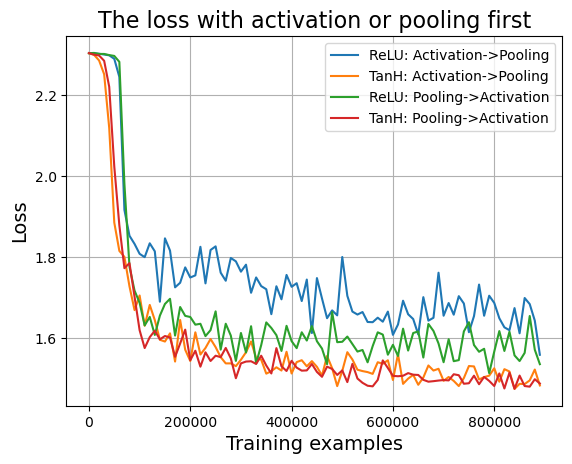

In [27]:
# Set the plot style
plt.style.use('default')

# Define data
x1 = range(0, len(relu_loss_vec) * batch_size*100, batch_size*100)
y1 = relu_loss_vec

x2 = range(0, len(tanh_loss_vec) * batch_size*100, batch_size*100)
y2 = tanh_loss_vec

x3 = range(0, len(relu_loss_vec_switched) * batch_size*100, batch_size*100)
y3 = relu_loss_vec_switched

x4 = range(0, len(tanh_loss_vec_switched) * batch_size*100, batch_size*100)
y4 = tanh_loss_vec_switched

# Clear current plot
plt.clf()


# Define figure
fig1 = plt.figure()

plt.plot(x1,y1, label="ReLU: Activation->Pooling")
plt.plot(x2,y2, label="TanH: Activation->Pooling")
plt.plot(x3,y3, label="ReLU: Pooling->Activation")
plt.plot(x4,y4, label="TanH: Pooling->Activation")

plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Loss", fontsize=14) 
plt.legend()
plt.grid()
plt.title("The loss with activation or pooling first", fontsize=16) 
plt.savefig("CNN_SGD_loss_switched.eps")
plt.show()

# Confusion matrix

In [18]:
def print_cm(model,test_loader):
    model = model.to("cpu")

    # Get model prediction
    for data, true_labels in test_loader:        
        output = model(data)
        _, model_pred = torch.max(output.data, 1)
    
    # Create confision matrix
    labels = [0,1,2,3,4,5,6,7,8,9]
    
    cm = confusion_matrix(true_labels, model_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    plt.savefig("confusion_matrix.eps")

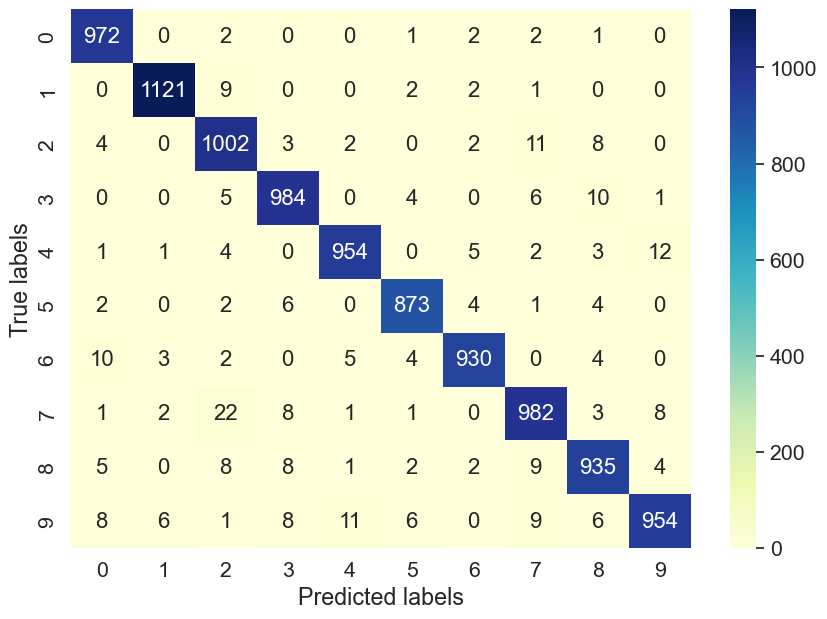

<Figure size 640x480 with 0 Axes>

In [19]:
print_cm(model,test_loader)

# Print mistakes

In [20]:
def print_mistakes(model,test_loader):
    model = model.to("cpu")
    
    # Get model prediction
    for data, true_labels in test_loader:        
        output = model(data)
        _, model_pred = torch.max(output.data, 1)
    
    # Find mistakes
    mistakes = (model_pred != true_labels)  # Logical array where "True" represent mistake
    mistakes_ids = torch.nonzero(mistakes)   # Extract array of indices of "True"
    
    # Select 5 random indices
    random_ids = np.random.choice(len(mistakes_ids), size=5)
    
    # Store 5 samples in a new array
    random_sample = mistakes_ids[random_ids]

    # Plot the sample
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(random_sample):  # i is fig counter, idx is image index
        # Data
        img = data[idx].reshape(28,28)
        true_label = true_labels[idx].item()
        predicted_label = model_pred[idx].item()
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True={true_label}  :  Pred={predicted_label}")
        axes[i].axis('off')

    plt.show()

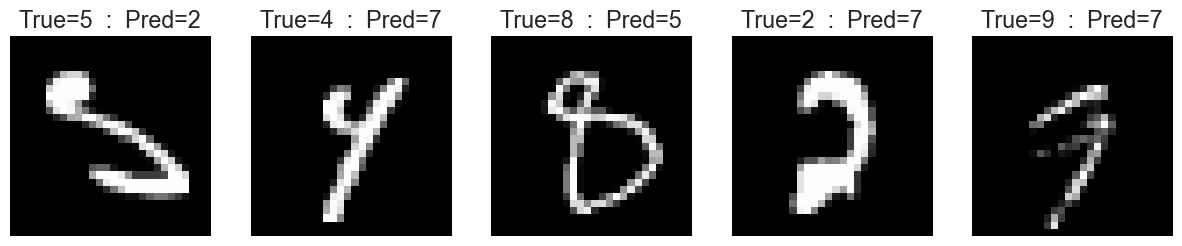

In [21]:
print_mistakes(model,test_loader)

# Intuition

In [22]:
# data is a torch tensor containing all test data: nr_samples, channels, width, height
# true_labels is a 1D torch tensor of the correct labels for each sample

idx = 261

for data, true_labels in test_loader:  
    print(f"data.shape = {data.shape}")
    print(f"true_labels.shape = {true_labels.shape}")
    print(f"true_labels[{idx}] = {true_labels[idx]}")
    
    output = model(data)
    val, model_pred = torch.max(output.data, 1) # return: max.col.val. and index for each row
    
    print()
    print(f"output.shape = {output.shape}")
    print(f"output[{idx}] = {output[idx]}")
    print(f"sum of output[{idx}] = {output[idx].sum()}")
    
    print()
    print(f"model_pred.shape = {model_pred.shape}")
    print(f"model_pred[{idx}] = {model_pred[idx]}")
    
    print()
    print(f"val.shape = {val.shape}")
    print(f"val[{idx}] = {val[idx]}  (how certain model is for idx {idx})")

data.shape = torch.Size([10000, 1, 28, 28])
true_labels.shape = torch.Size([10000])
true_labels[261] = 5

output.shape = torch.Size([10000, 10])
output[261] = tensor([2.1847e-07, 2.0915e-07, 1.7716e-06, 3.0957e-04, 8.2422e-13, 9.9963e-01,
        1.3559e-09, 1.3096e-06, 5.7560e-05, 3.6452e-07],
       grad_fn=<SelectBackward0>)
sum of output[261] = 1.0

model_pred.shape = torch.Size([10000])
model_pred[261] = 5

val.shape = torch.Size([10000])
val[261] = 0.999629020690918  (how certain model is for idx 261)
